# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


In [1]:
# Some of the pre-loaded imports
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

In [2]:
# Additional import statements made here
np.int = np.int_
np.float = np.float_
import nltk
import zipfile
import shutil
import html
import matplotlib
import matplotlib.pyplot as plt

#first, download the stopwords.zip file from https://www.nltk.org/nltk_data/ and then extract it
source_dir = '/Users/calebmccurdy/downloads/stopwords'
dest_dir = '/Users/calebmccurdy/nltk_data/corpora/stopwords'

if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)
shutil.move(source_dir, dest_dir)

#first, download the punkt.zip file from https://www.nltk.org/nltk_data/ and then extract it
punkt_source_dir = '/Users/calebmccurdy/downloads/punkt'
punkt_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/punkt'

if os.path.exists(punkt_dest_dir):
    shutil.rmtree(punkt_dest_dir)
shutil.move(punkt_source_dir, punkt_dest_dir)

'/Users/calebmccurdy/nltk_data/corpora/stopwords'

In [3]:
# Final remaining pre-loaded imports
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/calebmccurdy/Desktop/USD/ADS 509/Lyrics Assignment/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [80]:
def descriptive_stats(tokens, num_most_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens)) / len(tokens)
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        counter = Counter(tokens)
        most_common_tokens = counter.most_common(num_most_tokens)
        print(f"Five most common tokens: {most_common_tokens}")
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [96]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
Five most common tokens: [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: Including assertion statements in code is beneficial as a quality control check to ensure that everything is running as expected. If a value does not match the intended value, an error will be thrown which alerts of the discrepancy. For example, if we change the first assertion statement to be equal to 14 instead of 13, the error will be thrown as there are not 14 tokens in the data.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 

In [160]:
# Read in the lyrics data

# Define path to the lyrics folder
lyrics_folder_path = os.path.join(data_location, lyrics_folder)

# Dictionary to store lyrics and title data
lyrics_data = {}
title_data = {}

# Loop through each artist subfolder in the lyrics folder
for artist_folder in os.listdir(lyrics_folder_path):
    artist_path = os.path.join(lyrics_folder_path, artist_folder)

    # Check if it's a directory
    if os.path.isdir(artist_path):
        artist = artist_folder
        lyrics_data.setdefault(artist, {})
        title_data.setdefault(artist, {})
        # Loop through each txt file in the artist subfolder
        for file_name in os.listdir(artist_path):
        
            # Extract song name from the file name
            song = os.path.splitext(file_name)[0]
            file_path = os.path.join(artist_path, file_name)
                
            # Read the entire text data from the file
            # https://www.dataquest.io/blog/read-file-python/ 
            with open(file_path, 'r') as file:
                text_data = file.read()
                lyrics_data[artist][song] = text_data

            with open(file_path, 'r') as f:
                text_data_line = f.readline()
                title_data[artist][song] = text_data_line

# Now, we have the lyrics data in the 'lyrics_data' dictionary with artist and song names as keys.
# We also have the title data in the 'title_data' dictionary with artist and song names as keys.

In [202]:
# read in the twitter data

# Define the path to the twitter folder
twitter_folder_path = os.path.join(data_location, twitter_folder)

# Dictionary to store Twitter descriptions
twitter_data = {}

# Loop through each txt file in the twitter folder
for file_name in os.listdir(twitter_folder_path):
    if file_name.endswith("_data.txt"):
        artist = file_name.split("_")[0]
        file_path = os.path.join(twitter_folder_path, file_name)
        df = pd.read_csv(file_path, sep='\t', quoting=3)

        # Extract the 'description' column from the DataFrame
        descriptions = df['description'].tolist()
        twitter_data[artist] = descriptions

# Now, we have the twitter followers description data in the 'twitter_data' dictionary with artist as the key.

## Data Cleaning

Now clean and tokenize your data. Remove punctuation characters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 

In [166]:
punctuation = set(punctuation) # speeds up comparison

def clean_lyrics(text):
    # remove punctuation characters
    text = ''.join([char for char in text if char not in punctuation])
    # fold to lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in sw])
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def clean_title(text):
    # remove punctuation characters
    text = ''.join([char for char in text if char not in punctuation])
    # fold to lowercase
    text = text.lower()
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def clean_twitter(text):
    # remove punctuation characters
    text = ''.join([char for char in text if char not in punctuation])
    # fold to lowercase
    text = text.lower()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in sw])
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [169]:
# Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly. 
RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text):
    return RE_TOKEN.findall(text)

In [102]:
# create your clean twitter data here
cleaned_twitter_data = {}

# Clean and tokenize Twitter data
for artist, descriptions in twitter_data.items():
    cleaned_twitter_data[artist] = []
    for desc in descriptions:
        # Check if desc is not a float
        if not isinstance(desc, float):
            cleaned_desc = clean_twitter(desc)
            twitter_tokens = tokenize(cleaned_desc)
            cleaned_twitter_data[artist].append(twitter_tokens)

In [204]:
#####
##### Can be used for testing by removing comments (#s)
#####

#for artist, twitter_tokens in cleaned_twitter_data.items():
#    print(f"Artist: {artist}")
#    print(f"Descriptions:")
#    for toks in twitter_tokens[:10]:
#        print(f"- {toks}")
#    print("=" * 30)'''

In [162]:
# create your clean lyrics data here
cleaned_lyrics_data = {}

# Clean and tokenize lyrics data
for artist, songs in lyrics_data.items():
    cleaned_lyrics_data[artist] = {}
    for song, text in songs.items():
        cleaned_text = clean_lyrics(text)
        tokens = tokenize(cleaned_text)
        cleaned_lyrics_data[artist][song] = tokens

In [205]:
#####
##### Can be used for testing by removing comments (#s)
#####

#test_artist = 'CityAlight'
#test_song = 'cityalight_grace'

#if test_artist in cleaned_lyrics_data and test_song in cleaned_lyrics_data[test_artist]:
#    print(f"Tokens for {test_artist} - {test_song}:\n")
#    print(cleaned_lyrics_data[test_artist][test_song])
#else:
#    print(f"Tokens for {test_artist} - {test_song} not found.")


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [90]:
# For cleaned_lyrics_data
for artist, songs in cleaned_lyrics_data.items():
    artist_tokens = [tokens for song, tokens in songs.items()]
    all_artist_tokens = [token for sublist in artist_tokens for token in sublist]
    print(f"\nDescriptive Stats for Lyrics - Artist: {artist}")
    descriptive_stats(all_artist_tokens, verbose=True)


Descriptive Stats for Lyrics - Artist: robyn
There are 15284 tokens in the data.
There are 2170 unique tokens in the data.
There are 73674 characters in the data.
The lexical diversity is 0.142 in the data.
Five most common tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 252)]

Descriptive Stats for Lyrics - Artist: cher
There are 35932 tokens in the data.
There are 3707 unique tokens in the data.
There are 172600 characters in the data.
The lexical diversity is 0.103 in the data.
Five most common tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Descriptive Stats for Lyrics - Artist: CityAlight
There are 5277 tokens in the data.
There are 838 unique tokens in the data.
There are 26399 characters in the data.
The lexical diversity is 0.159 in the data.
Five most common tokens: [('jesus', 191), ('god', 150), ('lord', 79), ('day', 75), ('love', 75)]

Descriptive Stats for Lyrics - Artist: PatBarrett
There are 8378 tokens in t

In [105]:
# For cleaned_twitter_data
for artist, descriptions in cleaned_twitter_data.items():
    all_artist_tokens = [token for sublist in descriptions for token in sublist]
    print(f"\nDescriptive Stats for Twitter - Artist: {artist}")
    descriptive_stats(all_artist_tokens, verbose=True) 


Descriptive Stats for Twitter - Artist: cher
There are 16242158 tokens in the data.
There are 1217934 unique tokens in the data.
There are 92010972 characters in the data.
The lexical diversity is 0.075 in the data.
Five most common tokens: [('love', 217688), ('im', 139892), ('life', 125973), ('music', 90150), ('de', 73093)]

Descriptive Stats for Twitter - Artist: robynkonichiwa
There are 1524822 tokens in the data.
There are 230574 unique tokens in the data.
There are 9049001 characters in the data.
The lexical diversity is 0.151 in the data.
Five most common tokens: [('music', 15358), ('love', 11827), ('im', 9098), ('och', 7924), ('life', 7539)]


Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: If we left stopwords in the data, is is likely that they would make up most if not all of the "top 5 words" list. We can witness this as "im" which comes from "I'm" is not listed as a stopword despite its similar nature. This word is in the "top 5 words" of every call besides for CityAlight's lyrics. Given that "I'm" is not even one of the most common words among the stopwords list, the others would likely make up almost the entirety of the top 5 for each artist if left in the data.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: Given that worship songs often have more repetition than other songs, I expected CityAlight and Pat Burrett to both have relatively low lexical diversities. While they appear to have large ones compared to Cher based on their entire body of work, this is likely caused by the quantity of songs and tokens rather than song type. As an artist produced more songs, their total lexical diversity is likely to lower as increasingly more of the words will be repeated. Thus, the total lexical diversity results do not contradict the prior belief that worship songs will have lower values for this metric.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [98]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [206]:
emoj = re.compile(r"""[\U0001F100-\U0001FFFF]""", re.VERBOSE)

def emoji_tokenize(text):
    return emoj.findall(text)

In [125]:
def emoji_descriptive_stats(tokens, num_most_emojis = 10, verbose=True) :
    if verbose :        
        emoji_counter = Counter(tokens)
        most_common_emojis = emoji_counter.most_common(num_most_emojis)
        print(f"Ten most common emojis: {most_common_emojis}")
    
    return(emoji_counter)

In [122]:
# Create a dictionary to store emojis by artist
emojis_by_artist = {}

for artist, descriptions in twitter_data.items():
    emojis_by_artist[artist] = []
    for desc in descriptions:
        # Check if desc is not a float
        if not isinstance(desc, float):
            cleaned_desc_emoji = clean_twitter(desc)
            emoji_tokens = emoji_tokenize(cleaned_desc_emoji)
            emojis_by_artist[artist].append(emoji_tokens)

'# Print the top 10 emojis for each artist\nfor artist, emoji_counter in emojis_by_artist.items():\n    print(f"\nTop 10 emojis for {artist}:")\n    for emoji, count in emoji_counter.most_common(10):\n        print(f"{emoji}: {count}")'

In [126]:
for artist, emoji_descriptions in emojis_by_artist.items():
    all_artist_emojis = [token for sublist in emoji_descriptions for token in sublist]
    print(f"\nDescriptive Stats for Twitter - Artist: {artist}")
    emoji_descriptive_stats(all_artist_emojis, verbose=True) 


Descriptive Stats for Twitter - Artist: cher
Ten most common emojis: [('🌈', 47549), ('🏳', 33412), ('🇺', 25793), ('💙', 21379), ('🏻', 20930), ('🌊', 20223), ('🇸', 18309), ('💜', 16550), ('🇦', 15993), ('🏼', 15130)]

Descriptive Stats for Twitter - Artist: robynkonichiwa
Ten most common emojis: [('🌈', 4685), ('🏳', 3528), ('🏻', 1495), ('🇺', 1343), ('🇪', 1264), ('🇸', 1214), ('🏼', 1139), ('🇦', 960), ('💙', 809), ('💜', 739)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [147]:
hashtag = re.compile(r"#.+", re.VERBOSE)

def hash_tokenize(text):
    hash_found = re.findall(r'#.*', text)
    return hash_found

def clean_twitter_hash(text):
    # fold to lowercase
    text = text.lower()
    # remove stopwords
    #text = re.sub(sw, ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in sw])
    # remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [148]:
def hashtag_descriptive_stats(tokens, num_most_hashtags = 10, verbose=True) :
    if verbose :        
        hash_counter = Counter(tokens)
        most_common_hashtags = hash_counter.most_common(num_most_hashtags)
        print(f"Ten most common hashtags: {most_common_hashtags}")
    
    return(hash_counter)

In [149]:
# Create a dictionary to store emojis by artist
hashtags_by_artist = {}

for artist, descriptions in twitter_data.items():
    hashtags_by_artist[artist] = []
    for desc in descriptions:
        # Check if desc is not a float
        if not isinstance(desc, float):
            cleaned_desc_hashtag = clean_twitter_hash(desc)
            hash_tokens = hash_tokenize(cleaned_desc_hashtag)
            hashtags_by_artist[artist].append(hash_tokens)

In [150]:
for artist, hash_descriptions in hashtags_by_artist.items():
    all_artist_hashtags = [token for sublist in hash_descriptions for token in sublist]
    print(f"\nDescriptive Stats for Twitter - Artist: {artist}")
    hashtag_descriptive_stats(all_artist_hashtags, verbose=True) 


Descriptive Stats for Twitter - Artist: cher
Ten most common hashtags: [('#blacklivesmatter', 2000), ('#resist', 1629), ('#blm', 1042), ('#theresistance', 403), ('#teamfollowback', 366), ('#resistance', 344), ('#freebritney', 329), ('#', 310), ('#bidenharris2020', 169), ('#voteblue', 166)]

Descriptive Stats for Twitter - Artist: robynkonichiwa
Ten most common hashtags: [('#blacklivesmatter', 189), ('#blm', 80), ('#teamfollowback', 45), ('#', 38), ('#freebritney', 27), ('#resist', 16), ('#bitcoin', 15), ('#coys', 12), ('#blacktranslivesmatter', 12), ('#brokenrecord', 10)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [175]:
# The title_data was read earlier in the notebook for code optimization

def title_descriptive_stats(tokens, num_most_title = 10, verbose=True) :
    if verbose :        
        title_counter = Counter(tokens)
        most_common_title = title_counter.most_common(num_most_title)
        print(f"Ten most common words in song titles (w/ stopwords): {most_common_title}")
    
    return(title_counter)

# create your clean lyrics data here
cleaned_title_data = {}

# Clean and tokenize lyrics data
for artist, songs in title_data.items():
    cleaned_title_data[artist] = {}
    for song, text in songs.items():
        cleaned_title = clean_title(text)
        title_tokens = tokenize(cleaned_title)
        cleaned_title_data[artist][song] = title_tokens


# For cleaned_lyrics_data
for artist, songs in cleaned_title_data.items():
    artist_titles = [tokens for song, tokens in songs.items()]
    all_artist_titles = [token for sublist in artist_titles for token in sublist]
    print(f"\nDescriptive Stats for Title - Artist: {artist}")
    title_descriptive_stats(all_artist_titles, verbose=True)


Descriptive Stats for Title - Artist: robyn
Ten most common words in song titles (w/ stopwords): [('me', 11), ('you', 8), ('the', 8), ('my', 8), ('love', 6), ('to', 6), ('do', 5), ('should', 4), ('dont', 4), ('with', 4)]

Descriptive Stats for Title - Artist: cher
Ten most common words in song titles (w/ stopwords): [('the', 54), ('you', 41), ('love', 38), ('i', 32), ('to', 28), ('a', 26), ('me', 25), ('of', 21), ('in', 14), ('and', 13)]

Descriptive Stats for Title - Artist: CityAlight
Ten most common words in song titles (w/ stopwords): [('the', 12), ('is', 11), ('jesus', 8), ('my', 7), ('god', 6), ('i', 5), ('day', 4), ('of', 4), ('and', 4), ('all', 4)]

Descriptive Stats for Title - Artist: PatBarrett
Ten most common words in song titles (w/ stopwords): [('the', 10), ('i', 6), ('praise', 6), ('and', 5), ('is', 4), ('good', 4), ('my', 3), ('you', 3), ('sing', 3), ('to', 3)]


In [176]:
# The title_data was read earlier in the notebook for code optimization

def title_descriptive_stats2(tokens, num_most_title = 10, verbose=True) :
    if verbose :        
        title_counter = Counter(tokens)
        most_common_title = title_counter.most_common(num_most_title)
        print(f"Ten most common words in song titles (no stopwords): {most_common_title}")
    
    return(title_counter)

# create your clean lyrics data here
cleaned_title_data2 = {}

# Clean and tokenize lyrics data
for artist, songs in title_data.items():
    cleaned_title_data2[artist] = {}
    for song, text in songs.items():
        cleaned_title2 = clean_lyrics(text)
        title_tokens = tokenize(cleaned_title2)
        cleaned_title_data2[artist][song] = title_tokens


# For cleaned_lyrics_data
for artist, songs in cleaned_title_data2.items():
    artist_titles2 = [tokens for song, tokens in songs.items()]
    all_artist_titles2 = [token for sublist in artist_titles2 for token in sublist]
    print(f"\nDescriptive Stats for Title - Artist: {artist}")
    title_descriptive_stats2(all_artist_titles2, verbose=True)


Descriptive Stats for Title - Artist: robyn
Ten most common words in song titles (no stopwords): [('love', 6), ('dont', 4), ('u', 4), ('hang', 3), ('tell', 3), ('girl', 3), ('thing', 3), ('know', 3), ('kills', 2), ('time', 2)]

Descriptive Stats for Title - Artist: cher
Ten most common words in song titles (no stopwords): [('love', 38), ('man', 12), ('song', 11), ('dont', 10), ('come', 7), ('one', 7), ('believe', 6), ('time', 6), ('go', 6), ('heart', 6)]

Descriptive Stats for Title - Artist: CityAlight
Ten most common words in song titles (no stopwords): [('jesus', 8), ('god', 6), ('day', 4), ('christ', 3), ('praise', 2), ('love', 2), ('lord', 2), ('saviour', 2), ('strong', 2), ('kind', 2)]

Descriptive Stats for Title - Artist: PatBarrett
Ten most common words in song titles (no stopwords): [('praise', 6), ('good', 4), ('sing', 3), ('spirit', 3), ('better', 3), ('soul', 2), ('day', 2), ('lord', 2), ('way', 2), ('something', 2)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

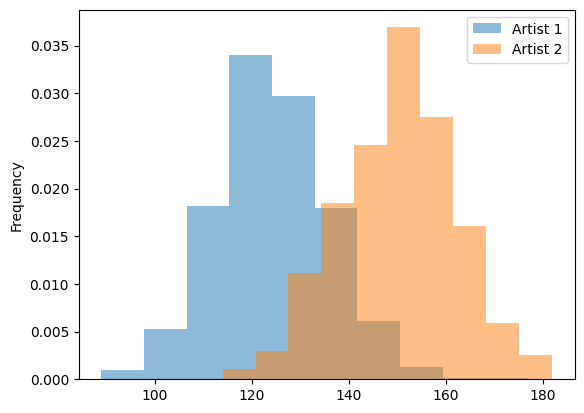

In [179]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: This regular expression matches on any whitespace character, 1 or more times.


In [185]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    #hash_found = re.findall(r'#.*', text)
    lyric = lyric.strip()
    return([item.lower() for item in collapse_whitespace.split(lyric)])

artist
CityAlight    Axes(0.125,0.11;0.775x0.77)
PatBarrett    Axes(0.125,0.11;0.775x0.77)
cher          Axes(0.125,0.11;0.775x0.77)
robyn         Axes(0.125,0.11;0.775x0.77)
Name: song_length, dtype: object

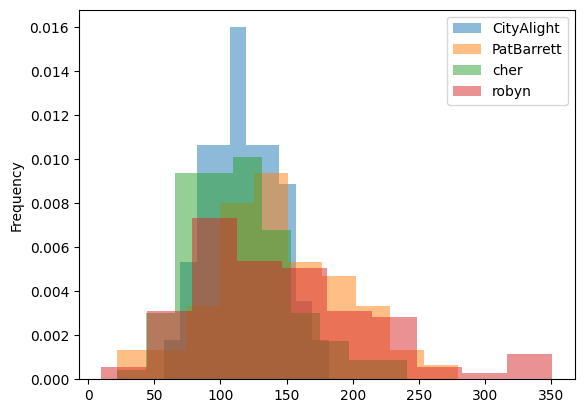

In [212]:
# Your lyric length comparison chart here. 

data_length = {}
for artist, songs in lyrics_data.items():
    data_length[artist] ={}
    for song, text in songs.items():
        cleaned_lyr = clean_lyrics(text)
        lyr_tokens = tokenize(cleaned_lyr)
        song_length = len(lyr_tokens)
        data_length[artist][song] = song_length

df = pd.DataFrame([(artist, song_len) for artist, songs in data_length.items() for song, song_len in songs.items()],
                                columns=['artist', 'song_length'])

# all histograms together
df.groupby('artist')['song_length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

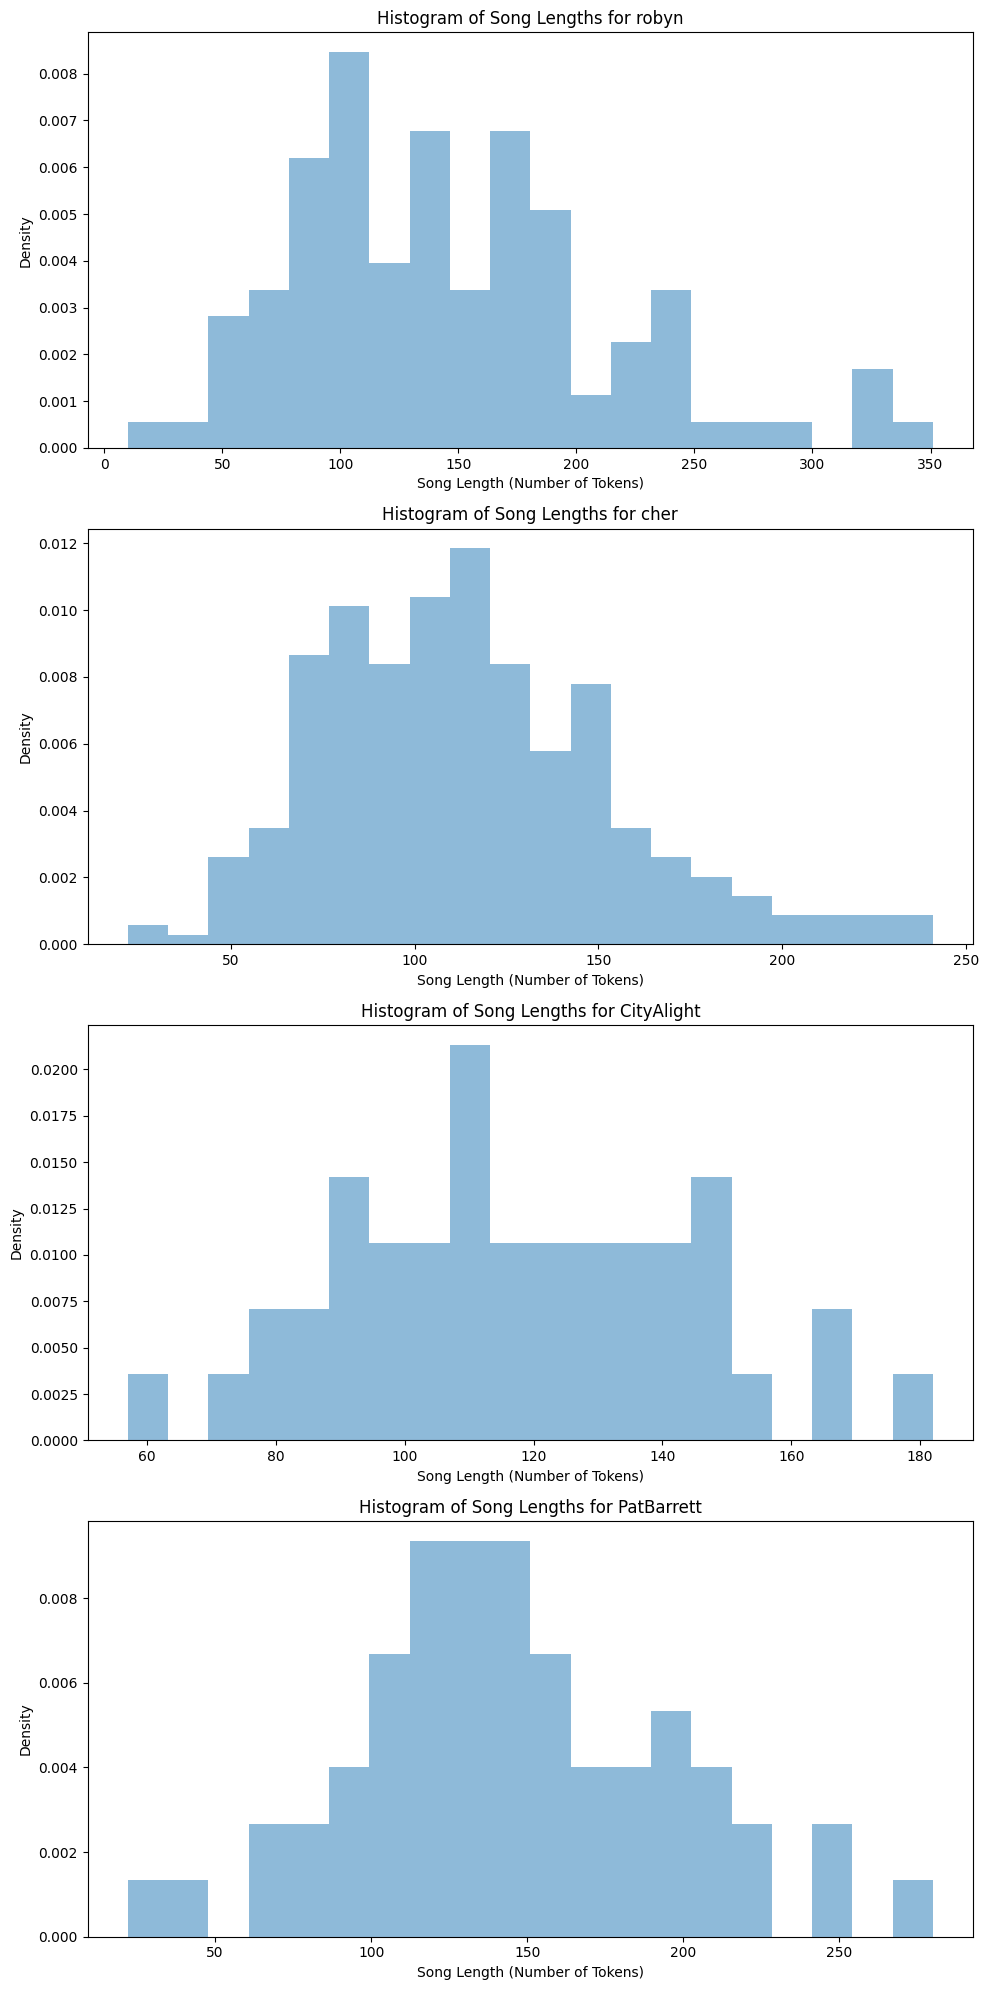

In [211]:
# Create subplots for each artist
artists = df['artist'].unique()
fig, axes = plt.subplots(nrows=len(artists), figsize=(10, 5 * len(artists)))

# Plot individual histograms for each artist
for ax, artist in zip(axes, artists):
    artist_data = df[df['artist'] == artist]
    ax.hist(artist_data['song_length'], bins=20, density=True, alpha=0.5)
    ax.set_title(f'Histogram of Song Lengths for {artist}')
    ax.set_xlabel('Song Length (Number of Tokens)')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()